# Monthly Digest Content

This aims to summarize the previous work and focus on what may relate to what we want to showcase to the client. The goal is to find ways to make it as easy as possible for the client to get insights on potential biases and have a general overview of what they focus on.

I begin with a brief overview of the data preprocessing (although it is still necessary to run the previous sections to obtain the data), then continue with the data analysis and finally a visualization. On it, I start by focusing on basic statistics like most popular regions (neighborhoods and census tracts), demographics of such places, and topic distributions. From there, I dive deeper into how race relates to all of this, and create visualizations that may allow the client to more quickly find areas of interest. 


Currently, I am focusing on 3 main ways of analyzing such data:

* **Direct Description**: The most straight-forward is by having a birds eye view of each neighborhood's topics, mentioned frequency, and demographics. This is also done by census, but still both require quite a bit of interpretation by the client. Further, when sample size is not big enough, it is hard to make conclusions and also requires to have an understanding of how populations relate to each other and what the norm or expectation is.

* **Predominant Race of Tract**: In here, I separate tracts depending on which race is the majority population and then use a heat map (also showed other potential visualizations) that describes how the topics are distributed among them. This has a couple of flaws too. It overlooks the amount of topics, but I tried to overcome this by normalizing the data. Then, it can leave quite a bit of valuable insight by simplifying tracts as a single race. Similarly, it also ignores how big the populations are on any given tract (as they can differ greatly).

* **Weighted by Population Size**: In here I attempt to overcome the simplification of using predominant race. I use the articles of any given topic, add up the populations, and give them an appropriate weight based on "coverage." In this way, we take into account the size of the population the article "refers" to, and also each individual race, as opposed to only the main one.

However, there still seems to be some shortcomings. Here's a couple I could think of:

* How good a proxy demographics is to article topic or coverage and how this can be used to inform on biases.
* How should articles be distributed, knowing that race is not spread evenly.
* Final approach has a heavy bias towards total population, and this might be missleading.
* There are a lot of topics and this makes it harder to distinguish patterns more cleanly (especially on smaller sample sizes)
* A lot of topics fall under the umbrella of "Other" so it makes it harder to focus on the rest, and good insight might be lost.
* How accurate we are at pinpointing the relevant location/person/etc the article covers and the appropriate topic.

In upcoming weeks, if results are favorable, we could also attempt to automate the finding of problem areas (any under/over representations) via statistical tests, such that the process is more streamlined.

Other things that might be interesting to look into are:

* Analyzing how article counts change over time by topic, demographic, and location, and see if there are any trends on season/month.
* Making the heatmaps interactive (show article/topic count, neighborhoods involved, or any other pertinent data)
* Probably very hard, but a sentiment analysis, or a more primitive version with common terms by article.

# Data Preprocessing

This just goes over loading the data, cleaning it up to leave only relevant fields, and formatting it.

In [2]:
import pandas as pd
from dateutil import parser
from datetime import datetime # for converting and using dates
import pytz

# Load data
articles = pd.read_csv("../../data/processed/gbh_geocoded_output.csv")
demographics = pd.read_csv("../../data/processed/demographics_by_tract.csv")

# Drop unnecessary columns
demographics = demographics.drop(columns=["Index", "Name", "State", "County"])

# Drop rows without neighborhoods
articles.dropna(subset=["Neighborhood"], inplace=True)

# Dictionary to map timezone names to pytz time zones
tzinfos = {'EST': pytz.timezone('US/Eastern'), 'EDT': pytz.timezone('US/Eastern')}

# Function to convert date strings to datetime objects
def convert_to_datetime(date_str):
    return parser.parse(date_str, tzinfos=tzinfos)

# Apply the conversion function to the 'Publication Date' column
articles['Publication Date'] = articles['Publication Date'].apply(convert_to_datetime)

# Ensure the Publication Date column is timezone-aware
articles['Publication Date'] = articles['Publication Date'].dt.tz_convert(pytz.timezone('US/Eastern'))


In [3]:
# Define the date range (example)
start_date = pytz.timezone('US/Eastern').localize(datetime(2020, 1, 1)) # All articles are after this date
end_date = pytz.timezone('US/Eastern').localize(datetime(2024, 12, 31))

# Filter the DataFrame for the date range
filtered_articles = articles[(articles['Publication Date'] >= start_date) & (articles['Publication Date'] <= end_date)]

In [4]:
# Extract year and month from the 'Publication Date' column
filtered_articles['Year-Month'] = filtered_articles['Publication Date'].dt.to_period('M')

# Count articles by year-month
articles_by_month = filtered_articles['Year-Month'].value_counts().sort_index()

# Get top 10 months with the most articles
top_10_months = articles_by_month.nlargest(10)

# Convert PeriodIndex to string for better readability in the table
top_10_months.index = top_10_months.index.astype(str)

# Create a DataFrame to display the top 10 months
top_10_months_df = top_10_months.reset_index()
top_10_months_df.columns = ['Year-Month', 'Number of Articles']

print("Top 10 months with most articles published:")
print(top_10_months_df.to_string(index=False))

Top 10 months with most articles published:
Year-Month  Number of Articles
   2023-03                  98
   2023-05                  79
   2024-03                  79
   2023-07                  78
   2023-04                  71
   2024-04                  71
   2024-02                  61
   2021-01                  51
   2023-10                  51
   2023-11                  44


C:\Users\axel0\AppData\Local\Temp\ipykernel_9292\3825588468.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  filtered_articles['Year-Month'] = filtered_articles['Publication Date'].dt.to_period('M')


For the monthly digest, we have to set up the relevant start and end date and filter the data set.

In [5]:
# Define the date range (example)
start_date = pytz.timezone('US/Eastern').localize(datetime(2023, 3, 1)) # This is the month with most published articles on the given data set
end_date = pytz.timezone('US/Eastern').localize(datetime(2023, 4, 1))

# Filter the DataFrame for the date range
filtered_articles = articles[(articles['Publication Date'] >= start_date) & (articles['Publication Date'] <= end_date)]

print(f"Using articles from {start_date.date()} to {end_date.date()}")
print(f"Number of articles: {len(filtered_articles)}")

Using articles from 2023-03-01 to 2023-04-01
Number of articles: 98


# Data Analysis

As mentioned, this will go over all the basics required to obtain the main visualizations.

### Article Counts

The client may want some basic overview of how their coverage looks. So this showcases the main neighborhoods, census tracts, and topics talked about.

In [6]:
# Function to get the top 5 category based on the number of articles
def get_article_count(data, column):
    count = data[column].value_counts()
    top_count = count.head(5)
    top_count_df = top_count.reset_index()
    top_count_df.columns = [column, "Article Count"]
    return top_count_df

# Count articles by Neighborhood
neighborhood_count = get_article_count(filtered_articles, "Neighborhood")
print("Top 5 Most Frequented Neighborhoods:\n", neighborhood_count.to_string(index=False))

# Count articles by Census Tract
tract_count = get_article_count(filtered_articles, "Census Tract")
print("\nTop 5 Most Frequented Census Tracts:\n", tract_count.to_string(index=False))

# Count articles by Topic
topic_count = get_article_count(filtered_articles, "Closest Topic")
print("\nTop 5 Most Frequented Topics:\n", topic_count.to_string(index=False))

Top 5 Most Frequented Neighborhoods:
 Neighborhood  Article Count
    Downtown             42
 Beacon Hill             12
      Fenway             11
    Back Bay              8
South Boston              6

Top 5 Most Frequented Census Tracts:
  Census Tract  Article Count
        30302             36
        20302             11
        10103              7
        10600              6
        90901              3

Top 5 Most Frequented Topics:
        Closest Topic  Article Count
               Other             16
      Local Politics             14
  Politics/Elections             11
Housing/Homelessness              8
     Labor/Workforce              4


In [7]:
all_topics_count = filtered_articles["Closest Topic"].value_counts()
print(f"There are {len(all_topics_count)} topics discussed")

There are 30 topics discussed


### Merge Articles with Demographics

This is just to make processing data easier.

In [8]:
# Function to merge articles with demographics
def merge_articles_with_demographics(articles_df, demographics_df):
    merged_df = pd.merge(articles_df, demographics_df, on='Census Tract', how='left')
    return merged_df

merged_articles = merge_articles_with_demographics(filtered_articles, demographics)

### Analyze Topics

In here, I get the main topics by tract and also allow a function to get them for any given tract. The client may want to view the topic distribution for any of the given neighborhoods/tracts, so on the website something like this could be added to make it interactive.

In [9]:
# Group by census tract and aggregate topics
topic_counts = merged_articles.groupby(['Census Tract', 'Closest Topic']).size().reset_index(name='counts')

# Determine all topics for each tract
all_topics = topic_counts.groupby('Census Tract')['Closest Topic'].apply(list).reset_index(name='All Topics')

# Determine the main 3 topics for each tract
top_3_topics = topic_counts.sort_values(['Census Tract', 'counts'], ascending=[True, False])
top_3_topics = top_3_topics.groupby('Census Tract').head(3).reset_index(drop=True)
main_3_topics = top_3_topics.groupby('Census Tract')['Closest Topic'].apply(list).reset_index(name='Main 3 Topics')

# Merge the results
result = pd.merge(all_topics, main_3_topics, on='Census Tract')

# Get the topics for a specific tract
def get_topics_for_tract(tract):
    topics = result[result["Census Tract"] == tract]
    formattedTopics = topics["Main 3 Topics"].values[0]
    formattedTopicss = str(formattedTopics[0]) + ", " + str(formattedTopics[1]) + ", " + str(formattedTopics[2])
    return formattedTopicss

# Show a couple of the results
result.head(5)

,Census Tract,All Topics,Main 3 Topics
0,102,[Labor/Workforce],[Labor/Workforce]
1,402,[Other],[Other]
2,502,[Other],[Other]
3,806,[Construction],[Construction]
4,10103,"[Addiction/Substance Use, Labor/Workforce, Loc...","[Other, Labor/Workforce, Addiction/Substance Use]"


### Analyze Demographics

This function allows to determine the population for a given demographic. We currently have the one for the census tract, but are missing the neighborhood one.

In [10]:
# Get race distribution for a given demographic (neighborhood/census tract)
def get_race_distribution(name, demographic):
    race_data = merged_articles[merged_articles[name] == demographic].copy()
    race_data = race_data.drop(columns=[ "Total", "Total Percent", "Hispanic or Latino", "Hispanic or Latino Percent",
                                        "Not Hispanic or Latino", "Not Hispanic or Latino Percent", "One Race Total", "One Race Total Percent"])
    
    # Drop duplicated census tracts to count each tract only once
    race_data = race_data.drop_duplicates(subset=["Census Tract"])
    
    race_data = race_data.drop(columns=["Index", "ID", "Coordinates", "Block", "Census Tract", "County", "Neighborhood", "Closest Topic", "Publication Date"])
    race_data = race_data.drop(columns=["White Percent", "African American Percent", "American Indian and Alaska Native Percent", 
                                        "Asian Percent", "Native Hawaiian and Other Pacific Island Percent", "Other Percent"])                           

    race_data = race_data.melt(var_name="Race", value_name="Population")
    return race_data


### Analyze main focuses

This is the first analysis attempt. It collects the most talked about neighborhood and census tract, gets the topic distribution, race distribution, and prepares it to be displayed.

In [11]:
# Get the top neighborhood and census tract by article count
top_neighborhood = get_article_count(merged_articles, "Neighborhood").iloc[0, 0]
top_census_tract = get_article_count(merged_articles, "Census Tract").iloc[0, 0]

# Get topic distribution for the top neighborhood
top_neighborhood_topics = merged_articles[merged_articles["Neighborhood"] == top_neighborhood]["Closest Topic"].value_counts()

top_neighborhood_race_distribution = get_race_distribution("Neighborhood", top_neighborhood)

# Get topic distribution for the top census tract
top_census_tract_topics = merged_articles[merged_articles["Census Tract"] == top_census_tract]["Closest Topic"].value_counts()

top_census_tract_race_distribution = get_race_distribution("Census Tract", top_census_tract)


In case it might be useful, we can also provide the census tracts under the neighborhood, which if clicked on the website, it should provide any of the expected data previously mentioned.

In [12]:
import textwrap # for wrapping output text

# Get the census tracts for a specific neighborhood
def get_tracts_for_neighborhood(data, neighborhood):
    return data[data["Neighborhood"] == neighborhood]["Census Tract"].unique()

neighborhood = top_neighborhood
tracts = get_tracts_for_neighborhood(articles, neighborhood)

tracts_str = ', '.join(map(str, tracts))
wrapped_tracts = textwrap.fill(tracts_str, width=100)
print(f"The {neighborhood} neighborhood has the following census tracts: \n{wrapped_tracts}")

The Downtown neighborhood has the following census tracts: 
981700, 70201, 70102, 30302, 30301, 70202, 70103, 70302


In [13]:
print(f"\nThe top neighborhood ({top_neighborhood}) race distribution is:")
top_neighborhood_race_distribution.groupby("Race").sum()


The top neighborhood (Downtown) race distribution is:


,Population
Race,
African American,286
American Indian and Alaska Native,2
Asian,1599
Native Hawaiian and Other Pacific Island,3
Other,35
White,4685


# Visualization

We can begin by visualizing the aforementioned areas so the client gets a general overview of their coverage: The most frequented neighborhoods, census tracts and topics.

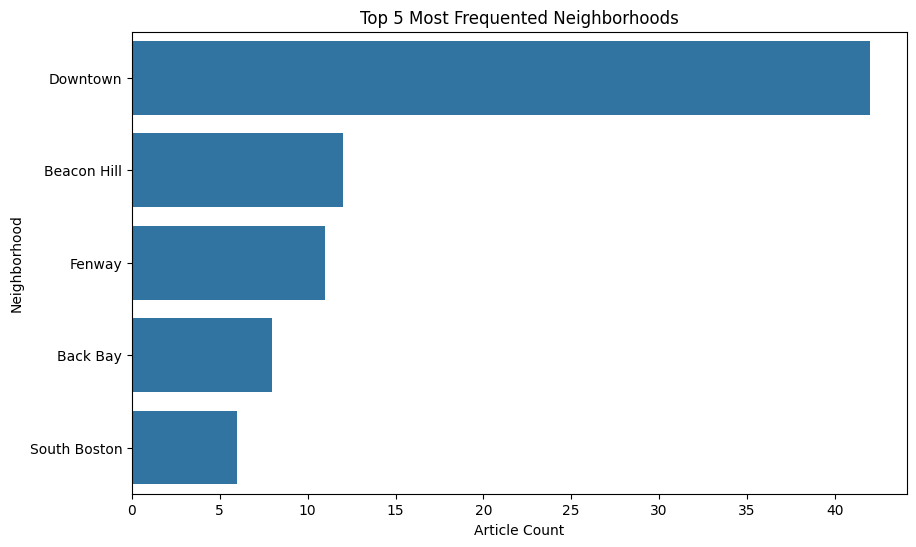

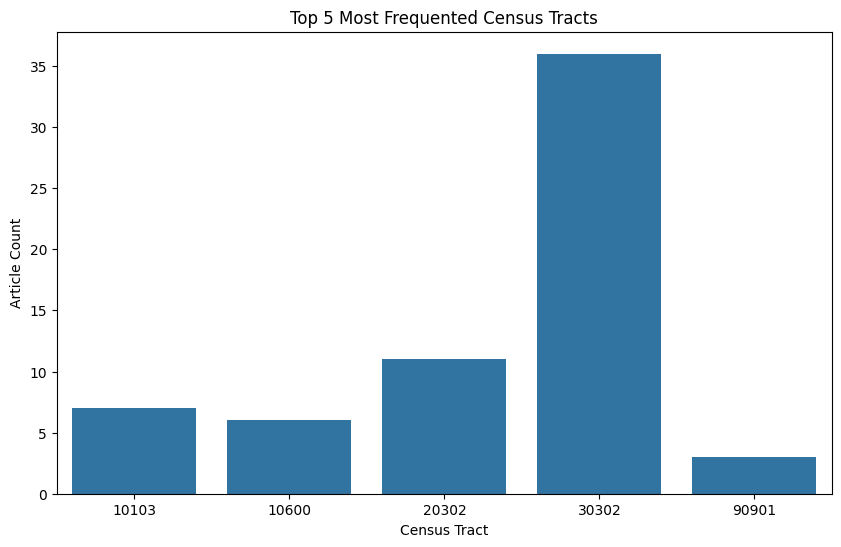

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Bar plot for Top 5 Neighborhoods by Article Count
plt.figure(figsize=(10, 6))
sns.barplot(x="Article Count", y="Neighborhood", data=neighborhood_count)
plt.title("Top 5 Most Frequented Neighborhoods")
plt.show()

# Bar plot for Top 5 Neighborhoods by Article Count
plt.figure(figsize=(10, 6))
sns.barplot(x="Census Tract", y="Article Count", data=tract_count)
plt.title("Top 5 Most Frequented Census Tracts")
plt.show()


# Pie chart for Top 5 Topics by Article Count
fig = px.pie(topic_count, names="Closest Topic", values="Article Count", title="Top 5 Most Frequented Topics")
fig.show()


To set a baseline, we can display the demographics of boston as a whole, and the overall topic distribution of their news outlet.

C:\Users\axel0\AppData\Local\Temp\ipykernel_9292\2539431641.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




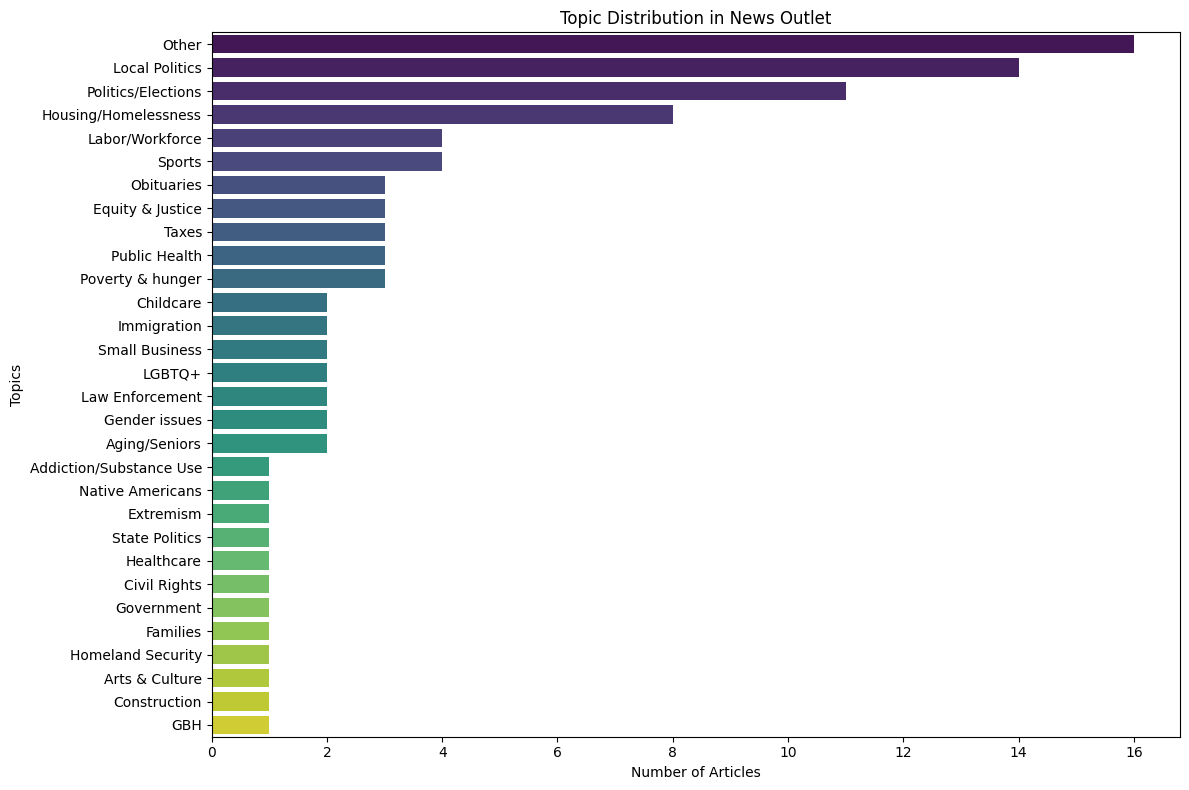

In [15]:
# Boston demographics https://www.census.gov/quickfacts/fact/table/bostoncitymassachusetts/PST045222
# Ignoring Two or More Races and Hispanic poulation
boston_demographics = {"White": 0.486, "African American": 0.225, "Asian": 0.097, "Other": 0.04}

# Convert the dictionary to a DataFrame
boston_demographics_df = pd.DataFrame(list(boston_demographics.items()), columns=['Race', 'Population'])

# Pie chart for Race distribution for the top neighborhood
fig = px.pie(boston_demographics_df, names="Race", values="Population", title='Boston Race Distribution')
fig.update_layout(width=800, height=600)
fig.show()

# We can also show the distribution of all articles by topics
plt.figure(figsize=(12, 8))
sns.barplot(x=all_topics_count.values, y=all_topics_count.index, palette="viridis")
plt.xlabel("Number of Articles")
plt.ylabel("Topics")
plt.title(f"Topic Distribution in News Outlet" )
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Then, we can visualize specific neighborhoods and census tracts. In this case, I decided to show the most talked about one, but we can make this interactive and allow the client to decide which one they want to see.

C:\Users\axel0\AppData\Local\Temp\ipykernel_9292\1961110789.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




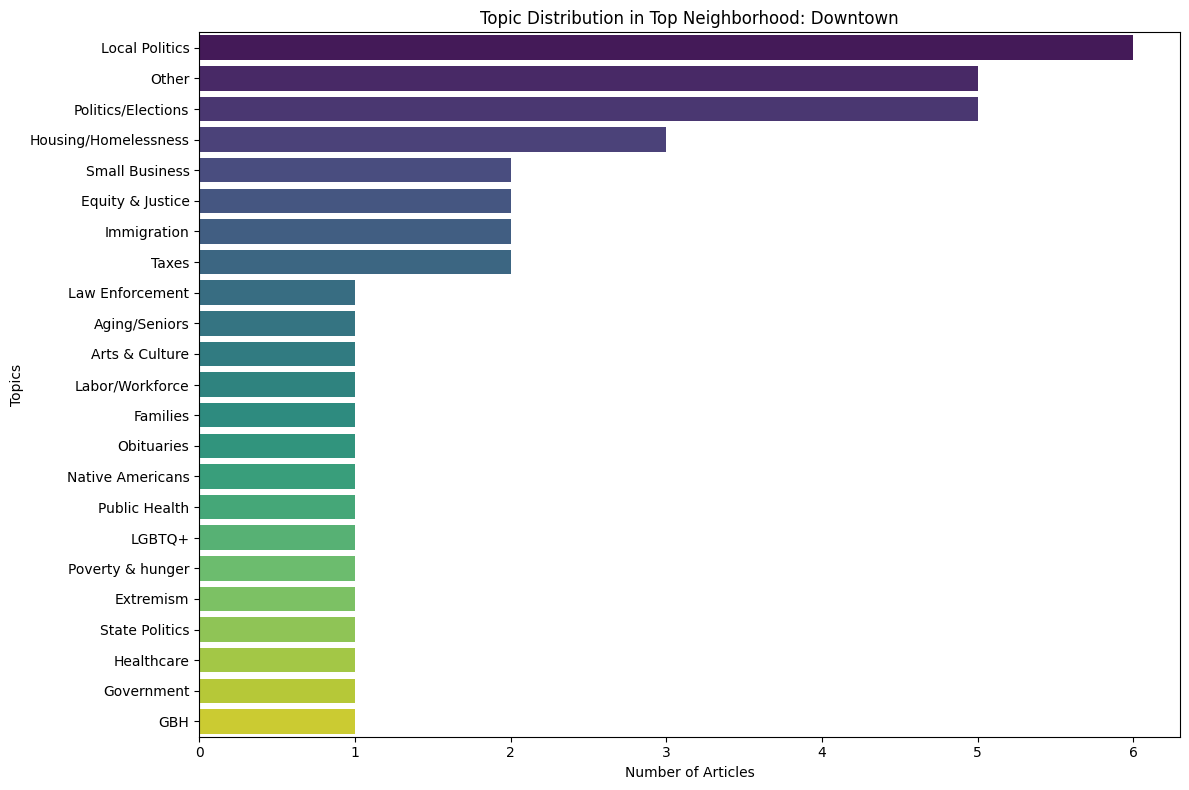

In [16]:
# Plotting topic distribution for the top neighborhood
plt.figure(figsize=(12, 8))
sns.barplot(x=top_neighborhood_topics.values, y=top_neighborhood_topics.index, palette="viridis")
plt.xlabel("Number of Articles")
plt.ylabel("Topics")
plt.title(f"Topic Distribution in Top Neighborhood: {top_neighborhood}")
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


top_neighborhood_race_distribution = top_neighborhood_race_distribution.groupby("Race").sum()

# Pie chart for Race distribution for the top neighborhood
fig = px.pie(top_neighborhood_race_distribution, names=top_neighborhood_race_distribution.index, values="Population", title=f'{top_neighborhood} Race Distribution')
fig.update_layout(width=800, height=600)
fig.show()


C:\Users\axel0\AppData\Local\Temp\ipykernel_9292\1378903810.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




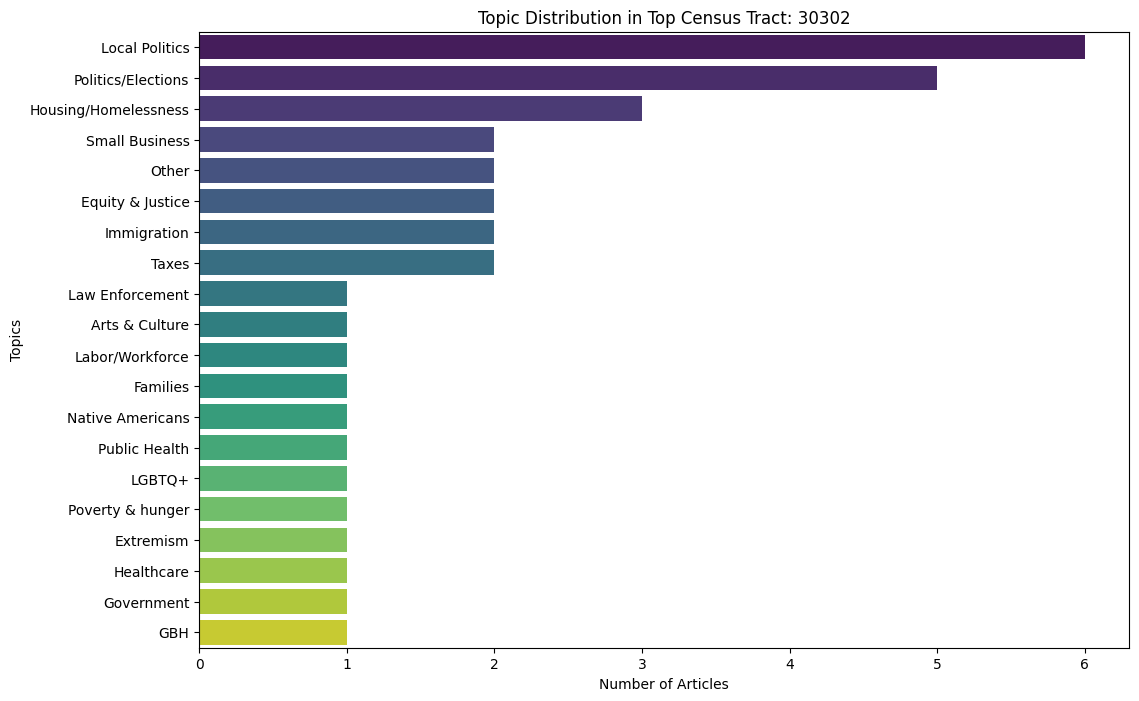

In [17]:
# Plotting topic distribution for the top census tract
plt.figure(figsize=(12, 8))
sns.barplot(x=top_census_tract_topics.values, y=top_census_tract_topics.index, palette="viridis")
plt.xlabel("Number of Articles")
plt.ylabel("Topics")
plt.title(f"Topic Distribution in Top Census Tract: {top_census_tract}")
plt.show()

top_census_tract_race_distribution = top_census_tract_race_distribution.groupby("Race").sum()

# Plotting race distribution for the top census tract
fig = px.pie(top_census_tract_race_distribution, names=top_census_tract_race_distribution.index, values="Population", title=f' {top_census_tract} Tract Race Distribution')
fig.update_layout(width=800, height=600)
fig.show()

# Further Race Analysis

This is where the client could get the most value and the one that needs the closest attention.

### Analyzing Patterns by predominant race of a given census tract

In here, I simplify by asigning tracts by the race they are most predominant on, and then count how many articles on any given topic there are, separating them by race.

In [18]:
import seaborn as sns
# Identify predominant race for each article
merged_articles['Predominant Race'] = merged_articles[['White', 'African American', 'American Indian and Alaska Native', 'Asian', 'Native Hawaiian and Other Pacific Island', 'Other']].idxmax(axis=1)

# Count articles by predominant race and topic
topics_by_race = merged_articles.groupby(['Predominant Race', 'Closest Topic']).size().unstack(fill_value=0)

# Delete the word Percent out of the names
topics_by_race.index = topics_by_race.index.str.replace(' Percent', '')

topics_by_race

Closest Topic,Addiction/Substance Use,Aging/Seniors,Arts & Culture,Childcare,Civil Rights,Construction,Equity & Justice,Extremism,Families,GBH,...,Native Americans,Obituaries,Other,Politics/Elections,Poverty & hunger,Public Health,Small Business,Sports,State Politics,Taxes
Predominant Race,,,,,,,,,,,,,,,,,,,,,
African American,0,0,0,0,0,0,0,0,0,0,...,0,1,2,0,1,0,0,0,0,0
Asian,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
White,1,1,1,2,1,1,2,1,1,1,...,1,2,14,10,2,3,2,4,1,3


However, this has the flaw of simplifying tracts into a single race, which further causes issues as most are predominantly white. This is best illustrated with the following article distribution:

In [19]:
predominant_race_counts = merged_articles['Predominant Race'].value_counts()
predominant_race_counts = predominant_race_counts.reset_index()
predominant_race_counts.columns = ["Predominant Race", "Tract Count"]
print(predominant_race_counts.to_string(index=False))

Predominant Race  Tract Count
           White           91
African American            4
           Asian            3


Similarly, we can view the distribution of predominant races across the tract counts (which informs us better over the previous one), where the predominantly white are still a majority, and by roughly triple of the African American.

In [20]:
unique_tracts = merged_articles.drop_duplicates(subset="Census Tract")
predominant_race_counts = unique_tracts['Predominant Race'].value_counts()
predominant_race_counts = predominant_race_counts.reset_index()
predominant_race_counts.columns = ["Predominant Race", "Tract Count"]
print(predominant_race_counts.to_string(index=False))

Predominant Race  Tract Count
           White           28
African American            4
           Asian            1


Finally, we can plot a heat map or stacked bar chart that displays such findings, whereas the brighter the color, the higher the topic count.

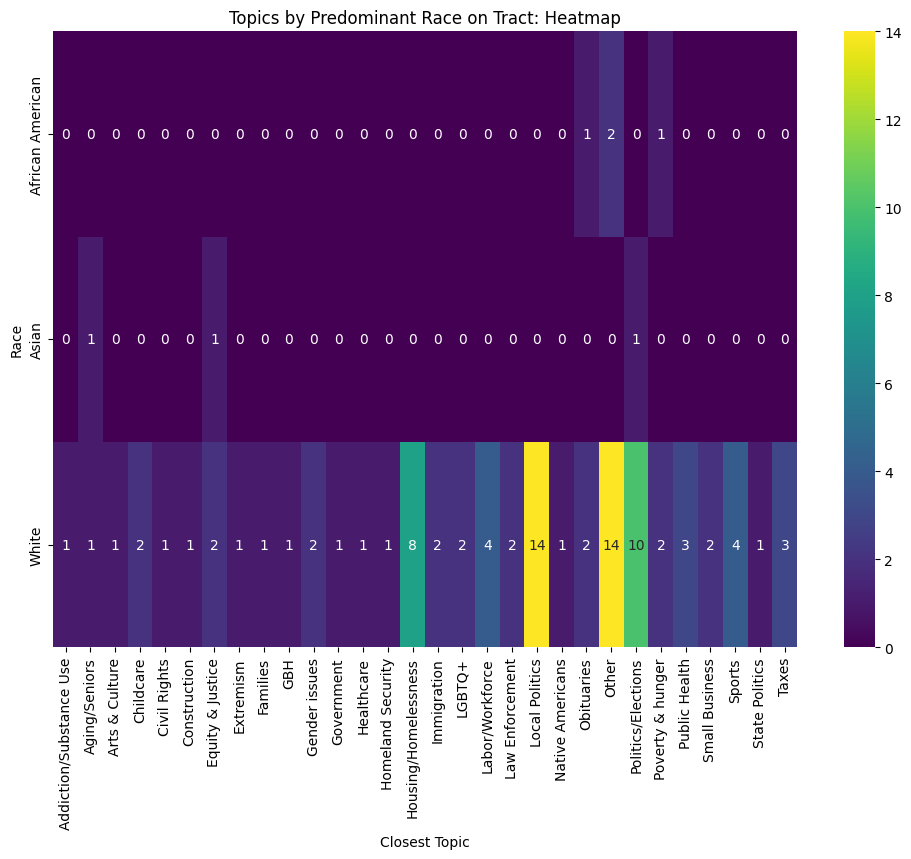

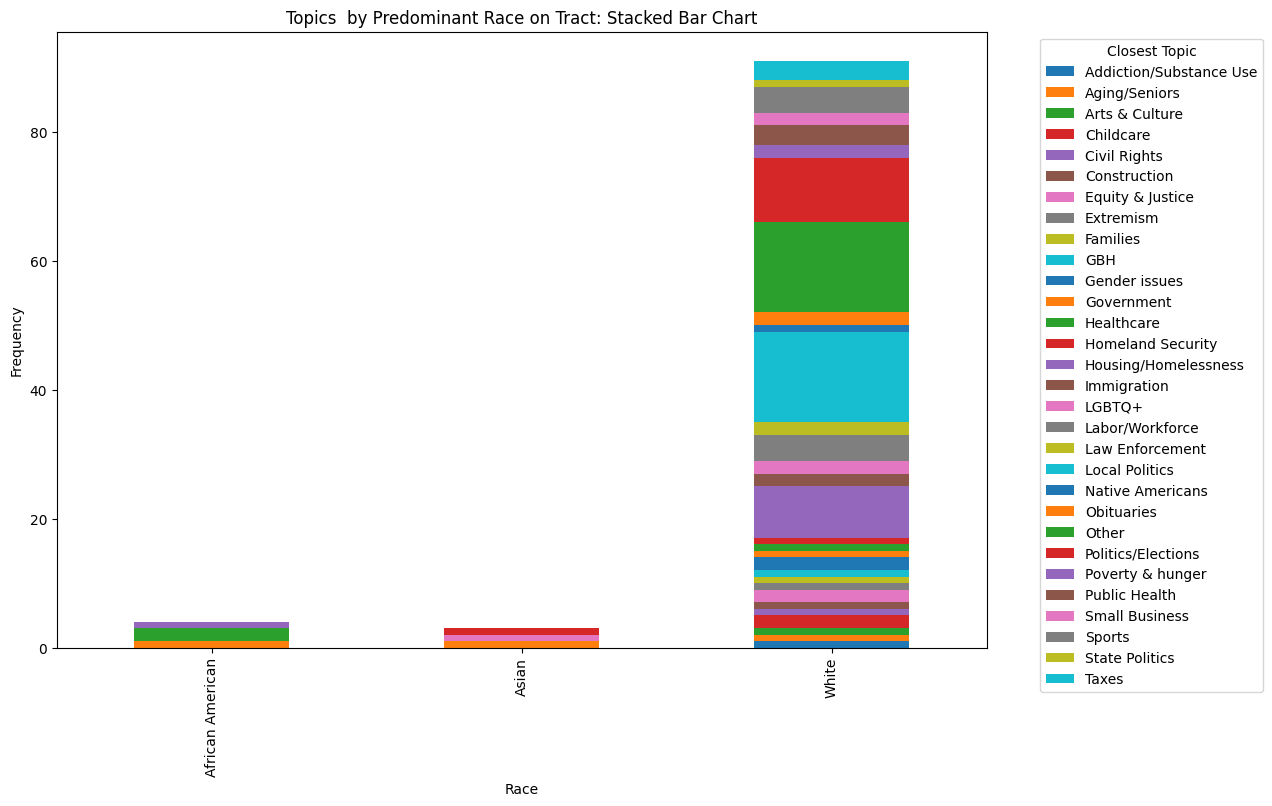

In [21]:
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(topics_by_race, cmap='viridis', annot=True, fmt='d')
plt.title('Topics by Predominant Race on Tract: Heatmap')
plt.xlabel('Closest Topic')
plt.ylabel('Race')
plt.show()

# Plot stacked bar chart
topics_by_race.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Topics  by Predominant Race on Tract: Stacked Bar Chart')
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.legend(title='Closest Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

This has a couple of issues, but let's begin by dropping the most popular topics to have a more balanced view of the rest

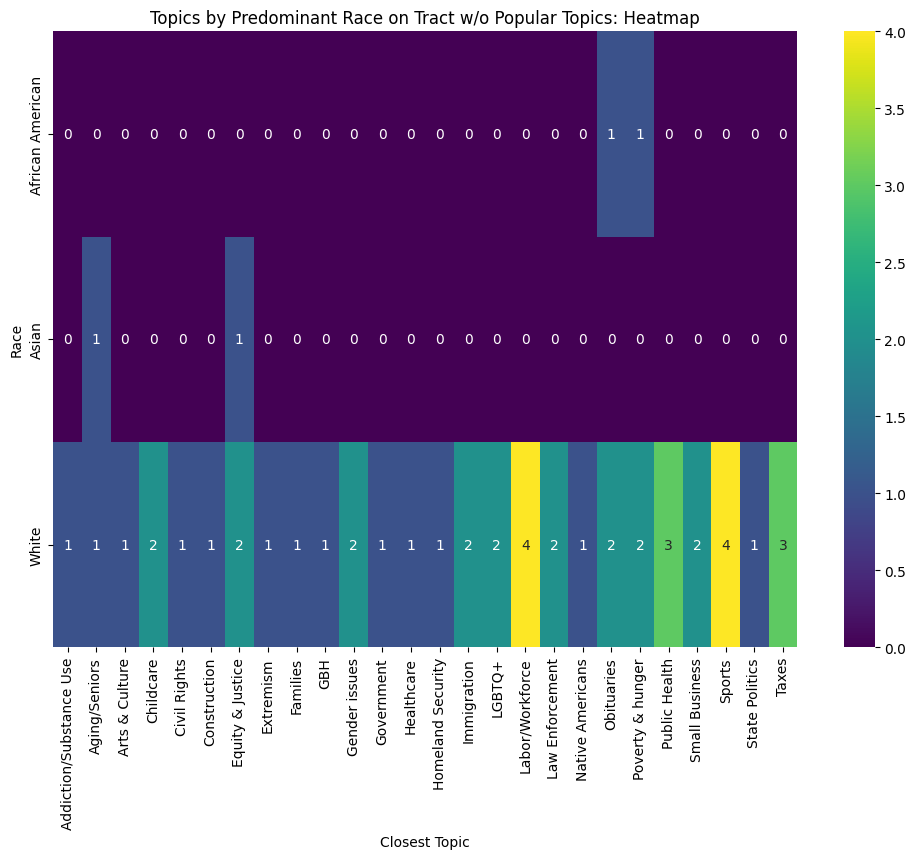

In [22]:
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(topics_by_race.drop(columns=["Other", "Local Politics", "Politics/Elections", "Housing/Homelessness"]), cmap='viridis', annot=True, fmt='d')
plt.title('Topics by Predominant Race on Tract w/o Popular Topics: Heatmap')
plt.xlabel('Closest Topic')
plt.ylabel('Race')
plt.show()

Even though this informs us better, it's not a great idea to just remove topics (other than potentially the "Other" category). So, I continued by instead of having a total count, normalizing each article count of a given topic and race, by the total amount of articles of such topic. This allows us to better see a proportional distribution of a topic on any given race, but misses to inform about the relative frequency compared to other topics.

In [23]:
# Normalize by total articles per topic

# Calculate total count for each topic
total_count_per_topic = topics_by_race.sum()

# Append a row representing the total count to the DataFrame
topics_by_race.loc['Total'] = total_count_per_topic

# Divide each column by the corresponding total count
topics_by_race_normalized = topics_by_race.div(topics_by_race.loc['Total'], axis=1)

# Round the values to two significant figures
topics_by_race_normalized = topics_by_race_normalized.round(2)

topics_by_race_normalized

Closest Topic,Addiction/Substance Use,Aging/Seniors,Arts & Culture,Childcare,Civil Rights,Construction,Equity & Justice,Extremism,Families,GBH,...,Native Americans,Obituaries,Other,Politics/Elections,Poverty & hunger,Public Health,Small Business,Sports,State Politics,Taxes
Predominant Race,,,,,,,,,,,,,,,,,,,,,
African American,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.33,0.12,0.00,0.33,0.0,0.0,0.0,0.0,0.0
Asian,0.0,0.5,0.0,0.0,0.0,0.0,0.33,0.0,0.0,0.0,...,0.0,0.00,0.00,0.09,0.00,0.0,0.0,0.0,0.0,0.0
White,1.0,0.5,1.0,1.0,1.0,1.0,0.67,1.0,1.0,1.0,...,1.0,0.67,0.88,0.91,0.67,1.0,1.0,1.0,1.0,1.0
Total,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,...,1.0,1.00,1.00,1.00,1.00,1.0,1.0,1.0,1.0,1.0


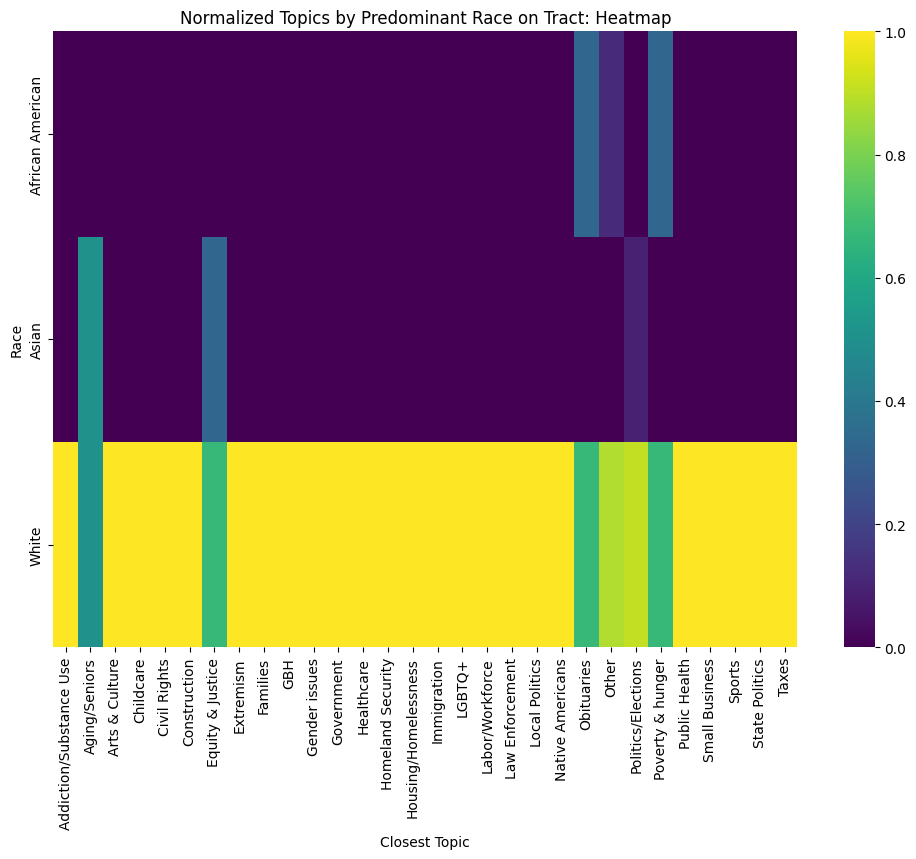

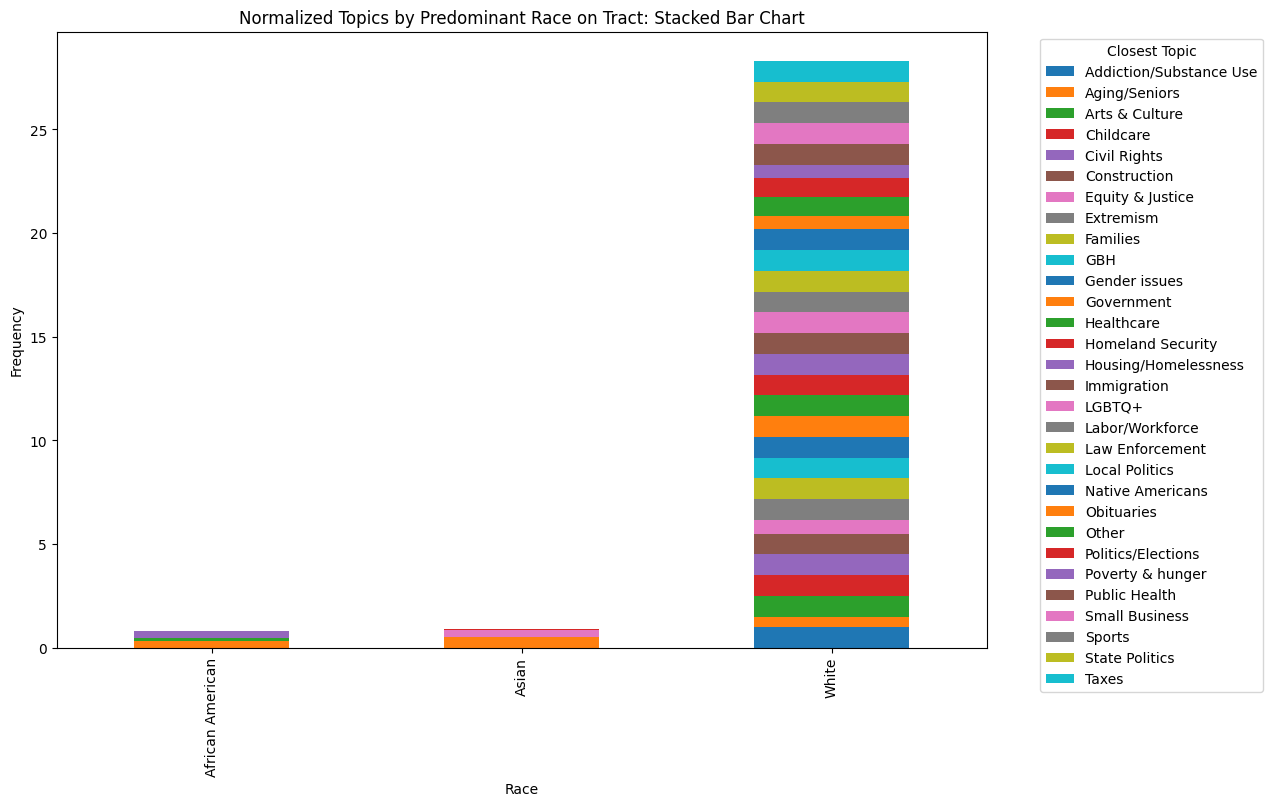

In [24]:

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(topics_by_race_normalized.drop('Total'), cmap='viridis')
plt.title('Normalized Topics by Predominant Race on Tract: Heatmap')
plt.xlabel('Closest Topic')
plt.ylabel('Race')
plt.show()

# Plot stacked bar chart
topics_by_race_normalized.drop('Total').plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Normalized Topics by Predominant Race on Tract: Stacked Bar Chart')
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.legend(title='Closest Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


With this one, it is much easier to see the distribution of each topic and how it biases towards the white population. However, it comes from assuming census tracts as purely of one race or another, which is generally not true. Further, it fails to account the population on each census, such that regardless of how big or small, it is accounted evenly.

### Trying alternative method: Calculate race population talked to by any given topic

##### That is, each article is associated with x population of varying demographics. Take into account the absolute amount of people it refers to, separated by race as well.


In [30]:
topics_by_race = merged_articles.groupby('Closest Topic')[['White', 'African American', 'American Indian and Alaska Native', 'Asian', 'Native Hawaiian and Other Pacific Island', 'Other']].sum()

# Aggregate fractional contributions by topic and racial group
topics_by_race_fractional = merged_articles.groupby('Closest Topic')[['White', 'African American', 'American Indian and Alaska Native', 'Asian', 'Native Hawaiian and Other Pacific Island', 'Other']].sum()


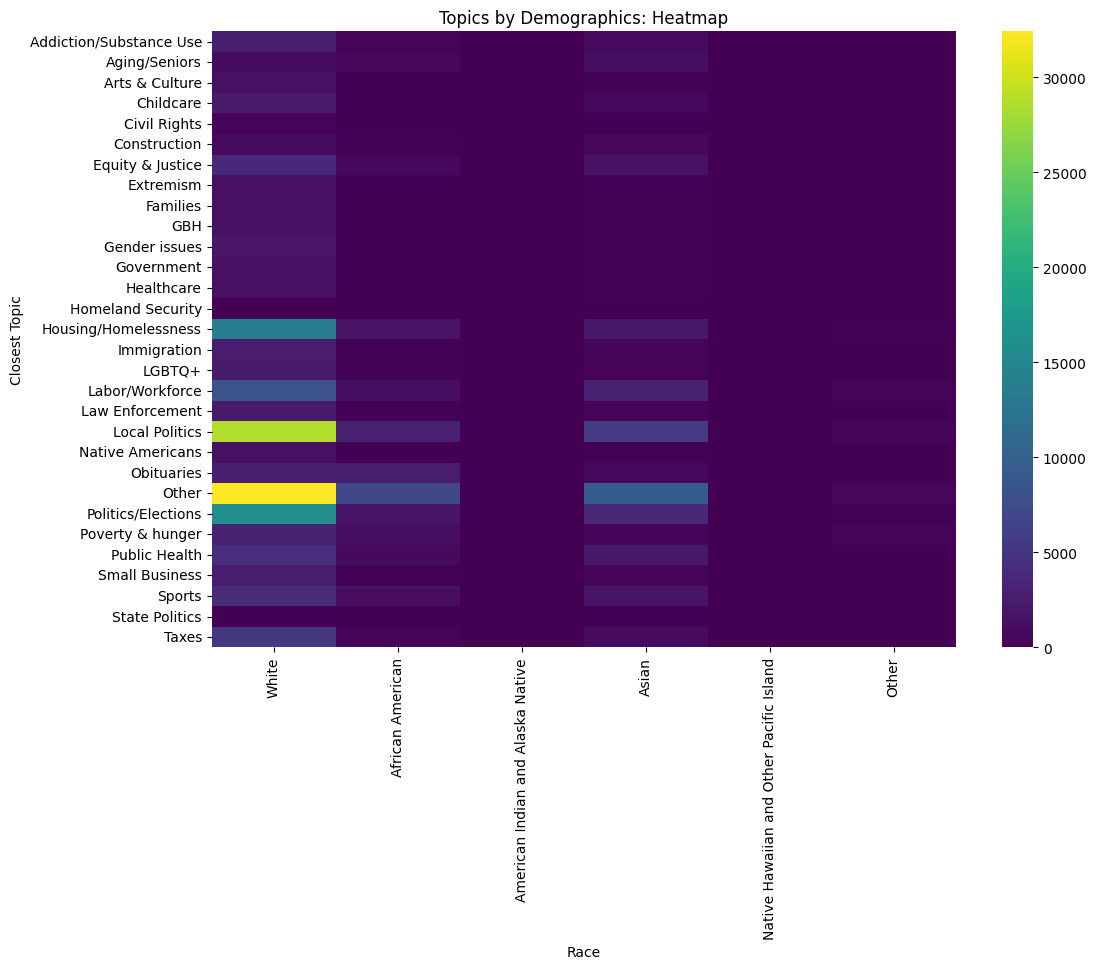

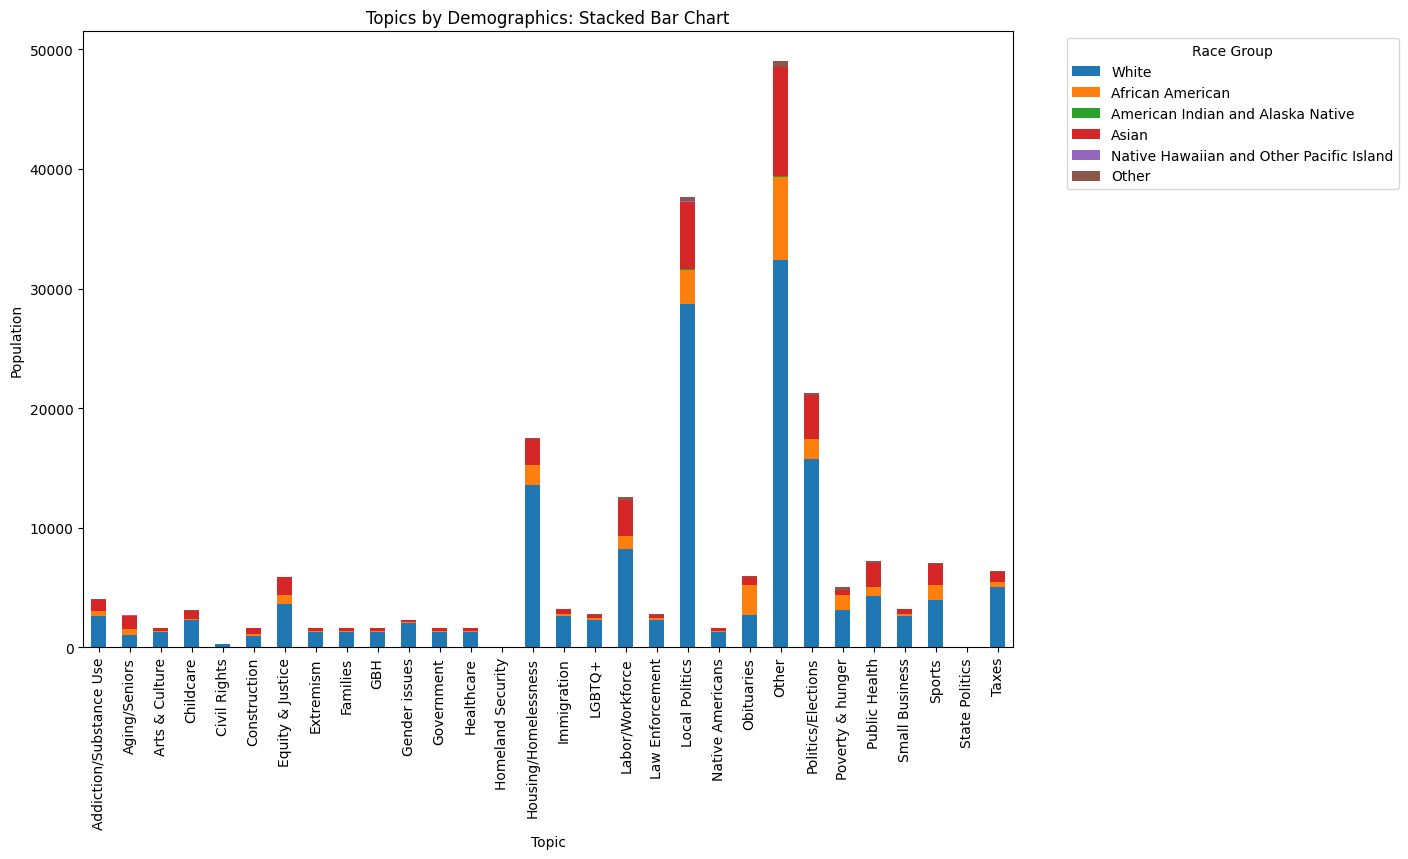

In [27]:
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(topics_by_race_fractional, cmap='viridis')
plt.title('Topics by Demographics: Heatmap')
plt.xlabel('Race')
plt.ylabel('Closest Topic')
plt.show()

# Plot stacked bar chart
topics_by_race_fractional.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Topics by Demographics: Stacked Bar Chart')
plt.xlabel('Topic')
plt.ylabel('Population')
plt.legend(title='Race Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

However, just as with the other graph, one can see the relative distribution of articles, but it is very hard to be informed about how it's biased by race. So, I again normalized by total population talked about

In [31]:
# Aggregate fractional contributions by topic and racial group
topics_by_race_fractional = merged_articles.groupby('Closest Topic')[['White', 'African American', 'American Indian and Alaska Native', 'Asian', 'Native Hawaiian and Other Pacific Island', 'Other']].sum()

# Calculate total population covered by each topic
total_population_per_topic = topics_by_race_fractional.sum(axis=1)

# Normalize the fractional contributions by dividing each column by the total population for that topic
topics_by_race_fractional_normalized = topics_by_race_fractional.div(total_population_per_topic, axis=0)



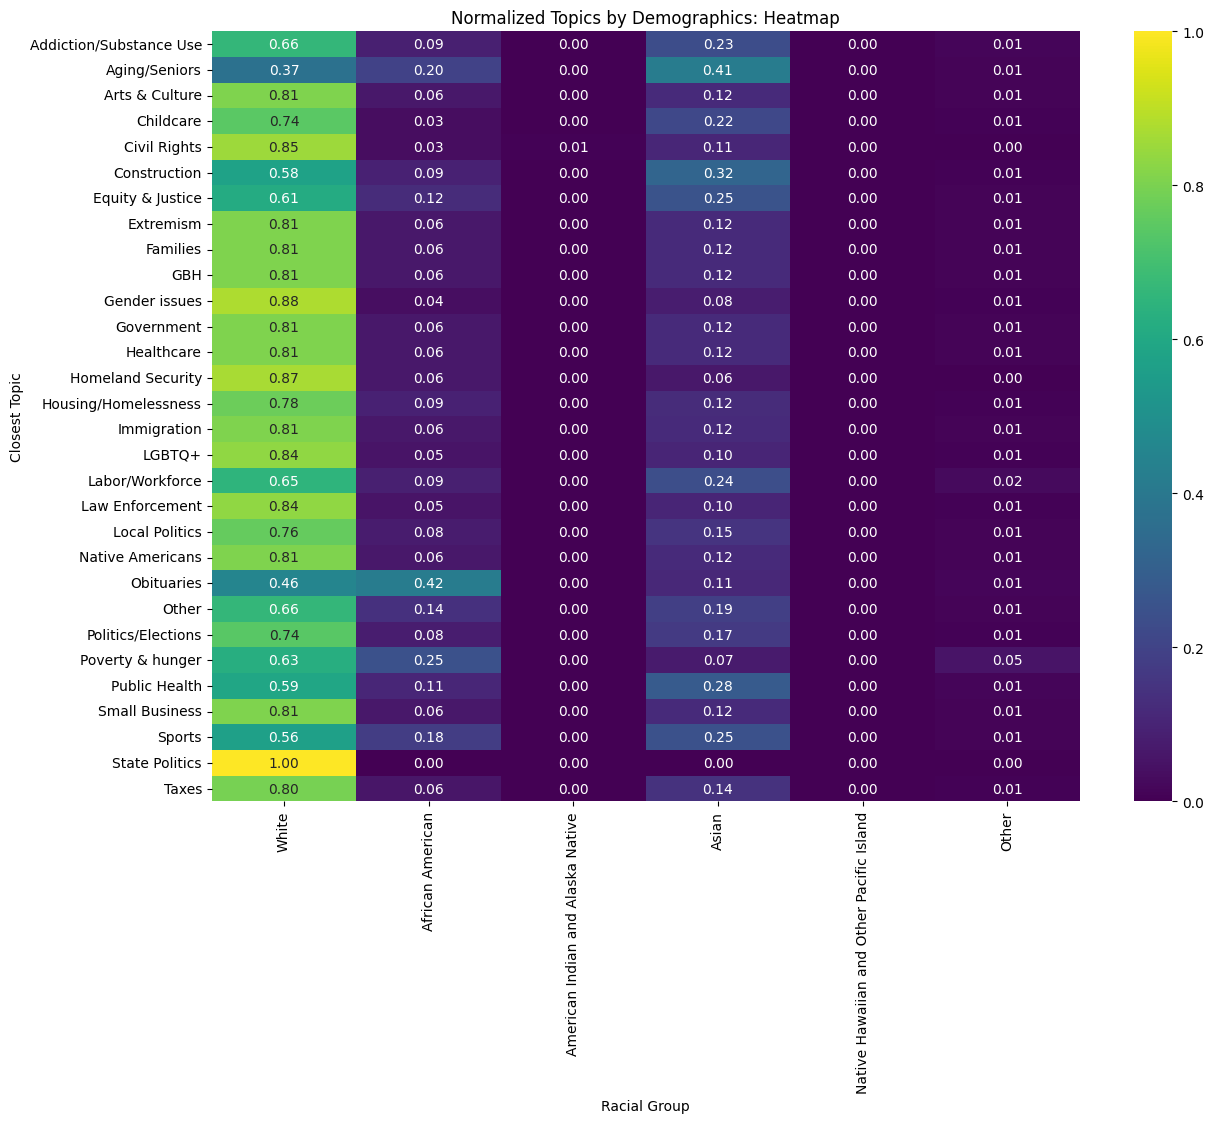

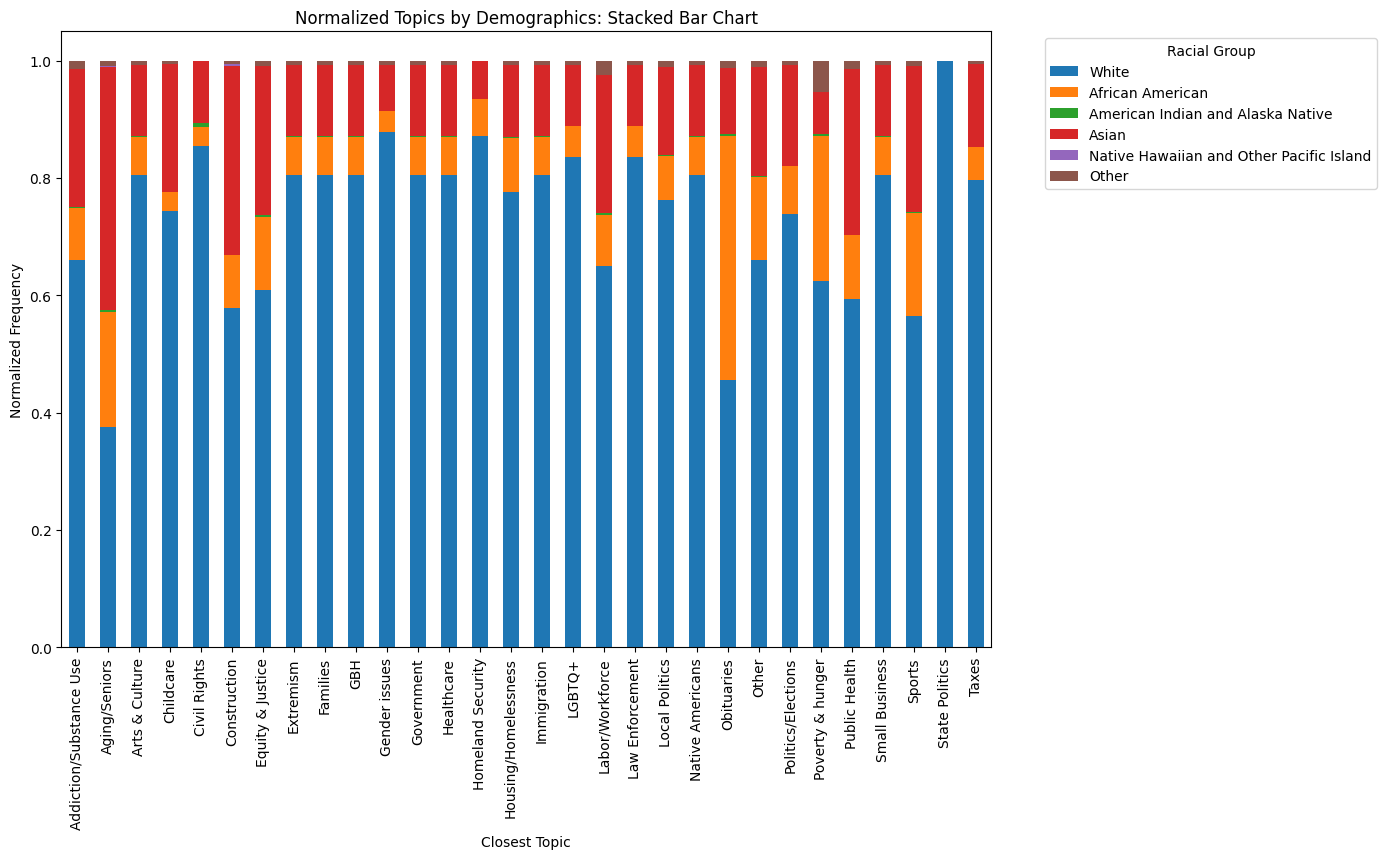

In [32]:
plt.figure(figsize=(14, 10))
sns.heatmap(topics_by_race_fractional_normalized, cmap='viridis', annot=True, fmt='.2f')
plt.title('Normalized Topics by Demographics: Heatmap')
plt.xlabel('Racial Group')
plt.ylabel('Closest Topic')
plt.show()

topics_by_race_fractional_normalized.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Normalized Topics by Demographics: Stacked Bar Chart')
plt.xlabel('Closest Topic')
plt.ylabel('Normalized Frequency')
plt.legend(title='Racial Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

This one I'm not sure if it's right, or even doing what I want it to do, but I wanted to divide by the total population of each individual race and somehow use that to take into account differences in population.

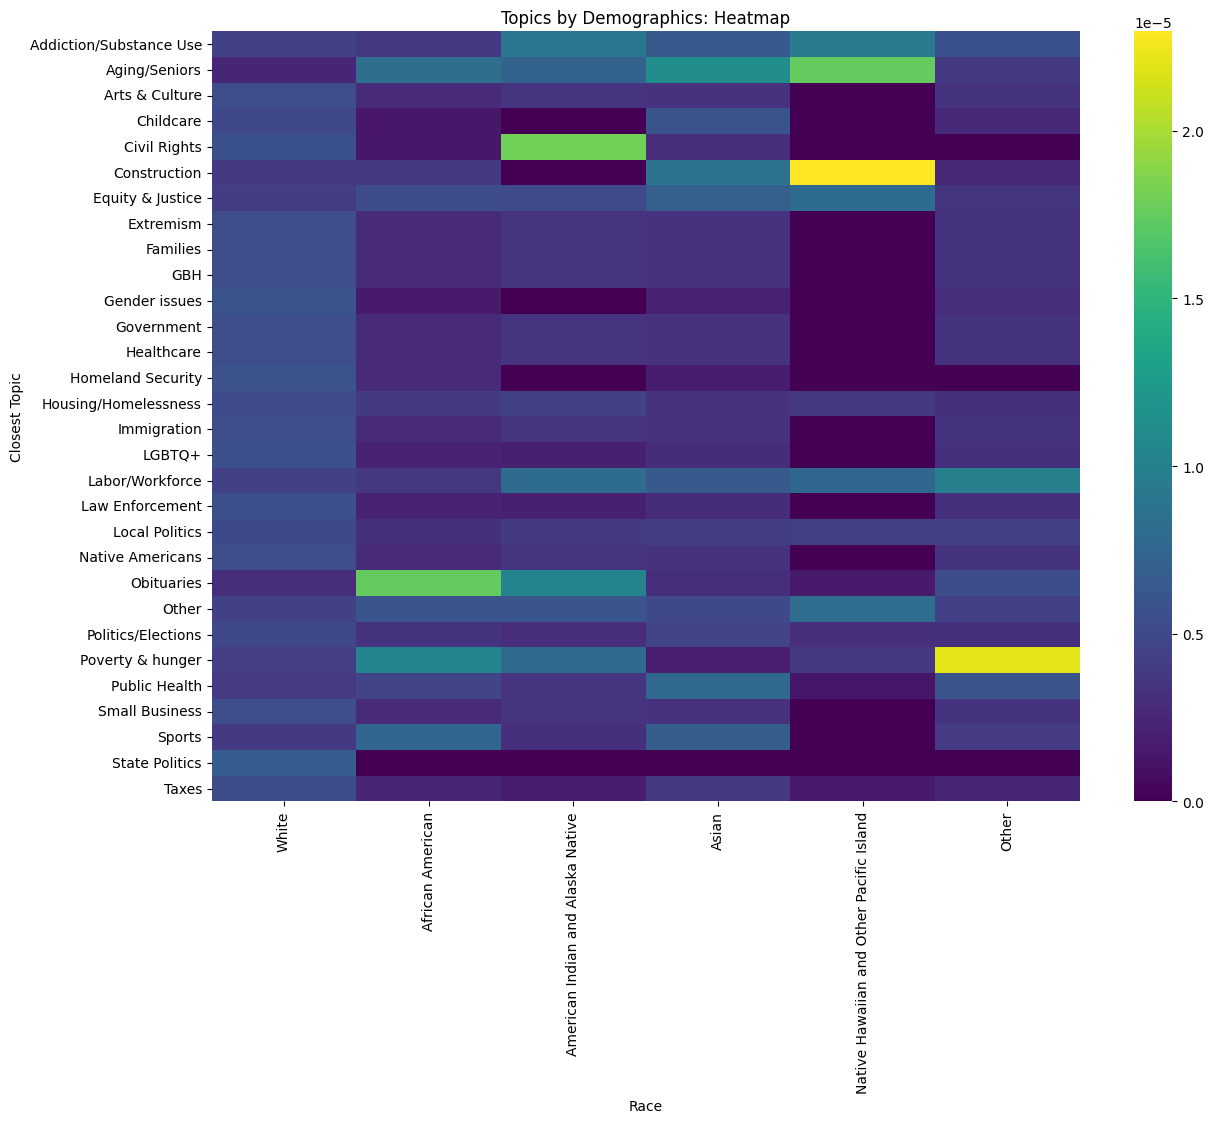

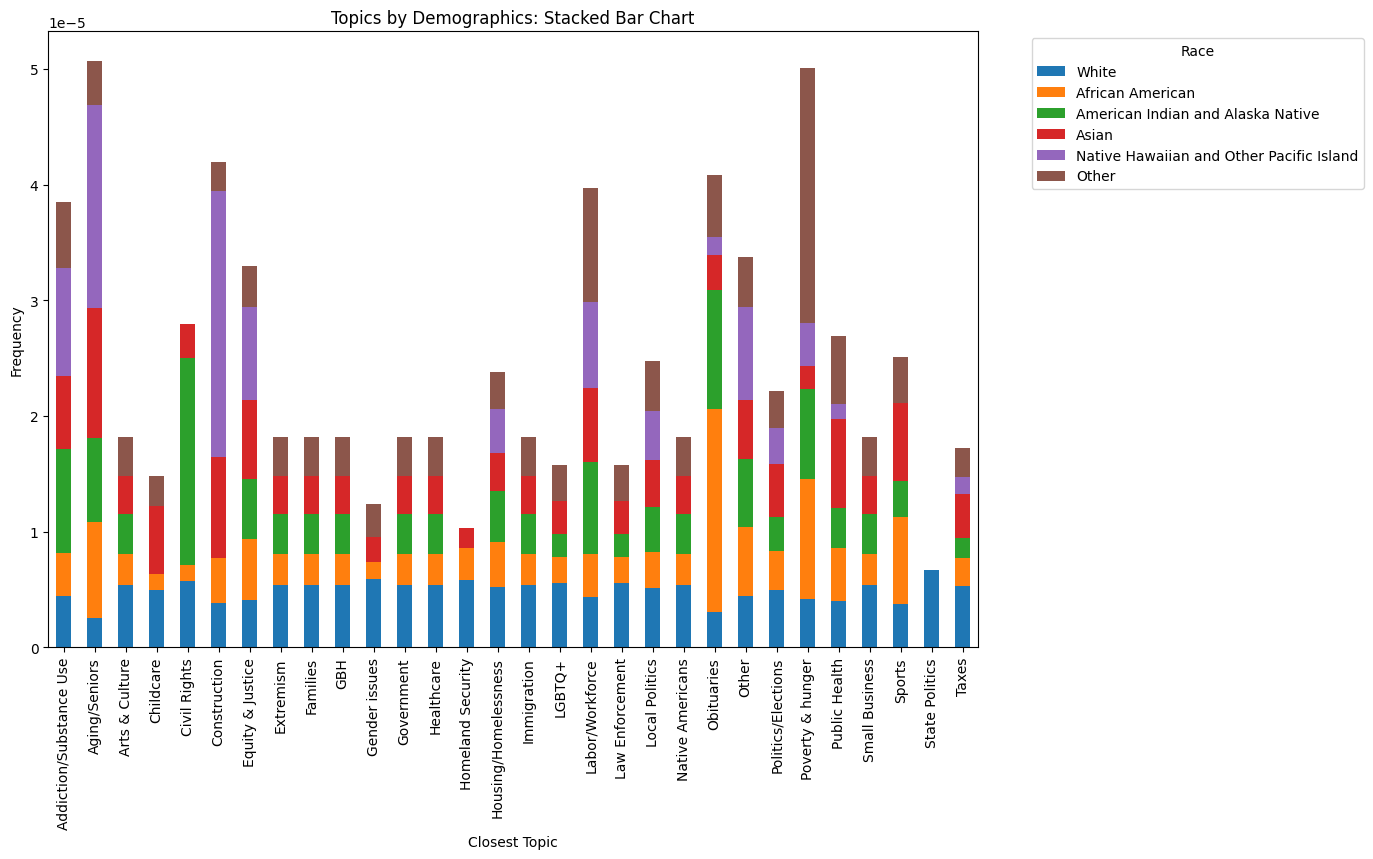

In [33]:
# Calculate total count for each racial group
total_count_per_race = merged_articles[['White', 'African American','American Indian and Alaska Native', 
                                        'Asian', 'Native Hawaiian and Other Pacific Island', 'Other']].sum()

# Divide each column by the corresponding total count
topics_by_race_fractional_normalized_demographics = topics_by_race_fractional_normalized.divide(total_count_per_race, axis=1)

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(topics_by_race_fractional_normalized_demographics, cmap='viridis')
plt.title('Topics by Demographics: Heatmap')
plt.xlabel('Race')
plt.ylabel('Closest Topic')
plt.show()

# Plot stacked bar chart
topics_by_race_fractional_normalized_demographics.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Topics by Demographics: Stacked Bar Chart')
plt.xlabel('Closest Topic')
plt.ylabel('Frequency')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Compare with Overall Boston Demographics

This method helps identify which topics have over- or under-representation of specific racial groups compared to the overall demographics of Boston.

In [70]:
# Normalize by Boston Demographics

# Boston demographics https://www.census.gov/quickfacts/fact/table/bostoncitymassachusetts/PST045222
# Ignoring Two or More Races and Hispanic poulation
boston_demographics = {"White": 0.5985, "African American": 0.2771, "Asian": 0.1195, "American Indian and Alaska Native": 0.003695, "Native Hawaiian and Other Pacific Island":0.001232, "Other": 0}

# Convert the dictionary to a DataFrame
boston_demographics_df = pd.DataFrame(list(boston_demographics.items()), columns=['Race', 'Population'])
boston_demographics_df = boston_demographics_df.set_index("Race")
boston_demographics_df["Population"] = round(boston_demographics_df["Population"]*100,2)

# Create a Series for easy division
boston_demographics_series = boston_demographics_df['Population'].reset_index(drop=True)

# Aggregate fractional contributions by topic and racial group
topics_by_race_fractional = merged_articles.groupby('Closest Topic')[['White', 'African American', 'American Indian and Alaska Native', 'Asian', 'Native Hawaiian and Other Pacific Island', 'Other']].sum()

# Ensure the race columns are in the same order
topics_by_race_fractional_normalized = topics_by_race_fractional_normalized[boston_demographics_df.index]

# Calculate total population covered by each topic
total_population_per_topic = topics_by_race_fractional.sum(axis=1)

# Normalize the fractional contributions by dividing each column by the total population for that topic
topics_by_race_fractional_normalized = 100*topics_by_race_fractional.div(total_population_per_topic, axis=0)

# Normalize by Boston demographics to find outliers
normalized_by_boston = topics_by_race_fractional_normalized.div(boston_demographics_df["Population"], axis=1)

# Replace inf and -inf values with zero after normalization
normalized_by_boston = normalized_by_boston.replace([float('inf'), float('-inf')], 0)

# Fill NaN values with zero after normalization
normalized_by_boston = normalized_by_boston.fillna(0)

normalized_by_boston


,African American,American Indian and Alaska Native,Asian,Native Hawaiian and Other Pacific Island,Other,White
Closest Topic,,,,,,
Addiction/Substance Use,0.315446,0.872489,1.957498,0.827746,0.0,1.104076
Aging/Seniors,0.711293,0.703567,3.466782,1.549523,0.0,0.626333
Arts & Culture,0.230444,0.335115,1.011655,0.000000,0.0,1.346619
Childcare,0.119241,0.000000,1.818938,0.000000,0.0,1.242172
Civil Rights,0.116413,1.743679,0.890808,0.000000,0.0,1.428302
Construction,0.329471,0.000000,2.699420,2.028809,0.0,0.965083
Equity & Justice,0.449117,0.502701,2.128132,0.704543,0.0,1.019062
Extremism,0.230444,0.335115,1.011655,0.000000,0.0,1.346619
Families,0.230444,0.335115,1.011655,0.000000,0.0,1.346619


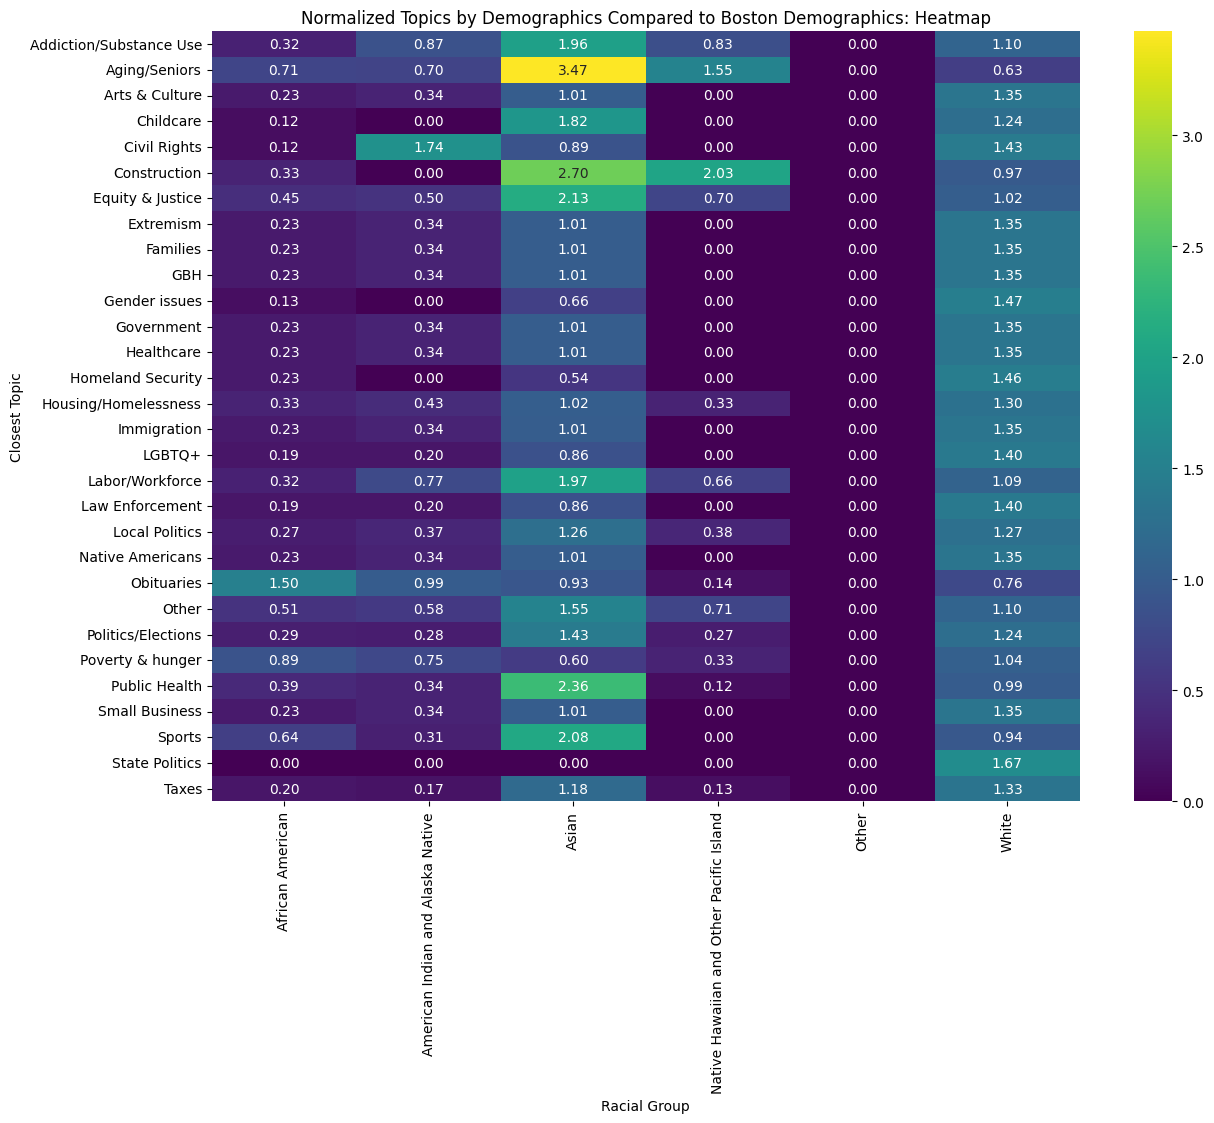

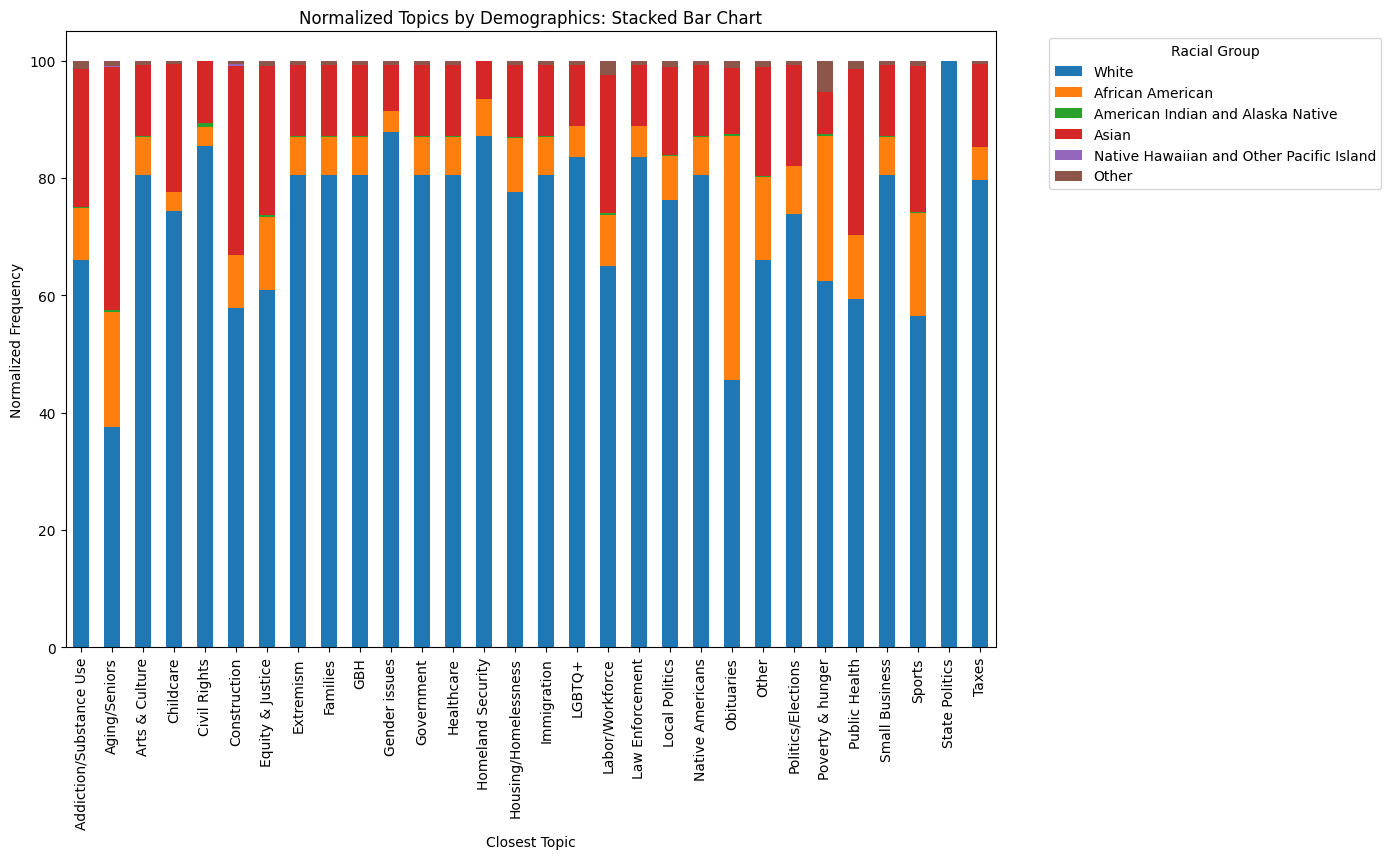

In [71]:
# Plot the heatmap to visualize the normalized by Boston demographics
plt.figure(figsize=(14, 10))
sns.heatmap(normalized_by_boston, cmap='viridis', annot=True, fmt='.2f')
plt.title('Normalized Topics by Demographics Compared to Boston Demographics: Heatmap')
plt.xlabel('Racial Group')
plt.ylabel('Closest Topic')
plt.show()

topics_by_race_fractional_normalized.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Normalized Topics by Demographics: Stacked Bar Chart')
plt.xlabel('Closest Topic')
plt.ylabel('Normalized Frequency')
plt.legend(title='Racial Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Report Generation

Not currently working. Will look into it in case it helps.